-- Notepad to myself --

# Challenge: Functions

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 

In [2]:
from pyspark.sql.functions import to_timestamp, col
df = spark.read.csv('data/Crimes-2021.csv', header=True, inferSchema=True) \
    .withColumn('Date', to_timestamp(col('Date'), 'MM/dd/yyyy hh:mm:ss a'))
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Challenge: What is the most frequently reported 'non-criminal' activity?

In [3]:
df.select(col('Primary Type')).distinct().count()

31

In [4]:
df.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(31, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN       |
|OTHER NARCOTIC VIOLATION         |
|OTHER OFFENSE                    |
|PROSTITUTION                     |
|PUBLIC INDECENCY           

In [6]:
nc = df.filter(col('Primary Type') == 'NON-CRIMINAL')
nc.count()

4

In [7]:
nc.groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+----------------------------------+-----+
|Description                       |count|
+----------------------------------+-----+
|CONCEALED CARRY LICENSE REVOCATION|4    |
+----------------------------------+-----+



### Challenge: Which day of the week has the most number of reported crime?

In [8]:
from pyspark.sql.functions import dayofweek

In [9]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    .. versionadded:: 2.3.0
    
    Examples
    --------
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]



In [10]:
df.select(col('Date'), dayofweek(col('Date'))).show(3)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2021-04-16 20:45:00|              6|
|2021-10-21 11:00:00|              5|
|2021-12-11 20:00:00|              7|
+-------------------+---------------+
only showing top 3 rows



In [11]:
from pyspark.sql.functions import date_format

In [12]:
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of `datetime pattern`_. can be used.
    
    .. _datetime pattern: https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html
    
    .. versionadded:: 1.5.0
    
    Notes
    -----
    Whenever possible, use specialized functions like `year`.
    
    Examples
    --------
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]



In [14]:
df.select(col('Date'), 
          dayofweek(col('Date')), 
          date_format(col('Date'), 'E')).show(3, truncate=False)

+-------------------+---------------+--------------------+
|Date               |dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2021-04-16 20:45:00|6              |Fri                 |
|2021-10-21 11:00:00|5              |Thu                 |
|2021-12-11 20:00:00|7              |Sat                 |
+-------------------+---------------+--------------------+
only showing top 3 rows



In [16]:
df.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).show(7, truncate=False)

+--------------------+-----+
|date_format(Date, E)|count|
+--------------------+-----+
|Fri                 |30924|
|Sat                 |30169|
|Sun                 |29882|
|Mon                 |29754|
|Wed                 |29233|
|Tue                 |29020|
|Thu                 |28897|
+--------------------+-----+



### Challenge: Using a bar chart, plot which day of the week has the most number of reported crime

To plot this; we'll need to use *pandas* and *matplotlib* as one potential solution. So why don't we work with the row objects instead? I'm going to collect that to allow me to access the row objects. If we're able to extract the day of the week, and the count, then we can plot them against each other. So we can easily do this with a list comprehension, and all we need to do is capture the first element and the second element of this row object.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df.groupBy(date_format(col('Date'), 'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=29882),
 Row(date_format(Date, E)='Mon', count=29754),
 Row(date_format(Date, E)='Thu', count=28897),
 Row(date_format(Date, E)='Sat', count=30169),
 Row(date_format(Date, E)='Wed', count=29233),
 Row(date_format(Date, E)='Fri', count=30924),
 Row(date_format(Date, E)='Tue', count=29020)]

In [19]:
dow = [x[0] for x in df.groupBy(date_format(col('Date'), 'E')).count().collect()]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [20]:
cnt = [x[1] for x in df.groupBy(date_format(col('Date'), 'E')).count().collect()]
cnt

[29882, 29754, 28897, 30169, 29233, 30924, 29020]

In [21]:
dc = pd.DataFrame({'Day_of_week':dow, 'Count':cnt})
dc

,Day_of_week,Count
0,Sun,29882
1,Mon,29754
2,Thu,28897
3,Sat,30169
4,Wed,29233
5,Fri,30924
6,Tue,29020


Text(0.5, 1.0, 'No. of reported crimes per day of the week on 2021')

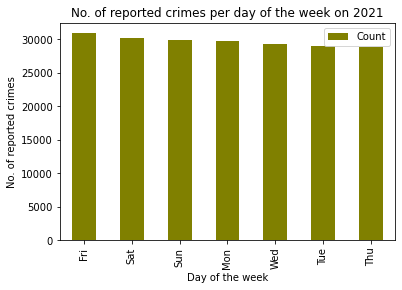

In [33]:
dc.sort_values('Count', ascending=False).plot(kind='bar', color='olive', x='Day_of_week', y='Count')
plt.xlabel('Day of the week')
plt.ylabel('No. of reported crimes')
plt.title('No. of reported crimes per day of the week on 2021')